In [1]:
import os
import warnings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import sklearn
import scipy
import scipy.stats as stats

import missingno as msno
import plotly.graph_objects as go
%matplotlib inline

from sklearn import base
from collections import defaultdict
from matplotlib.ticker import FixedLocator, FixedFormatter
from joblib import dump, load
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, GridSearchCV, \
RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold, KFold
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, KernelPCA
from kmodes.kprototypes import KPrototypes
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
df = pd.read_excel("data.xlsx",sheet_name='Sheet1', usecols="A:K")
#converting from korean won to us dollar
df['Direct_insurance_costs']= df['Direct_insurance_costs']/1337
df['Indirect_insurance_costs']= df['Indirect_insurance_costs']/1337
df=df.dropna()


C:\Users\COM\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():


In [3]:
column=['Human_damage_death','Human_damage_injuries','Construction_type_classification_code','Work_process_classification','Injury_area_Classification','Accident_type_classification','Workers_affiliation','Integrated_occupation_classification','Direct_insurance_costs','Direct_insurance_cost_total_category_code','Total_loss_cost_classification_code']
df1=df[column]
df1

,Human_damage_death,Human_damage_injuries,Construction_type_classification_code,Work_process_classification,Injury_area_Classification,Accident_type_classification,Workers_affiliation,Integrated_occupation_classification,Direct_insurance_costs,Direct_insurance_cost_total_category_code,Total_loss_cost_classification_code
0,1,0,CT2,WP03,IA01,AT06,WP1,IJ61,100972.326103,DC6,TAC6
1,0,1,CT2,WP16,IA07,AT03,WP0,IJ62,0.000000,DC1,TAC2
2,0,1,CT1,WP03,z,AT18,WP0,IJ62,0.000000,DC1,z
3,0,1,CT1,WP03,z,AT01,WP0,IJ61,0.000000,DC1,z
4,0,1,CT1,WP13,z,AT01,WP0,IJ61,0.000000,DC1,z
...,...,...,...,...,...,...,...,...,...,...,...
973,0,1,CT2,WP41,IA07,AT04,WP1,IJ61,1267.928197,DC2,TAC2
974,0,1,CT1,WP24,IA07,AT02,WP1,IJ61,12383.649963,DC4,TAC4
975,0,1,CT1,WP40,IA07,AT18,WP1,IJ61,3163.448018,DC2,TAC2
976,0,1,CT1,WP04,IA07,AT01,WP1,IJ61,9617.501870,DC4,TAC4


In [4]:
#Removing unclassified total cost type from dataset
df1 = df1[df1.Total_loss_cost_classification_code != 'z']

In [5]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
# example of oversampling a multi-class classification dataset
from pandas import read_csv
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from xgboost import XGBClassifier
X = df1.drop(columns=['Total_loss_cost_classification_code'])
y = df1['Total_loss_cost_classification_code']
encoder = ce.OrdinalEncoder(cols=['Construction_type_classification_code','Work_process_classification','Injury_area_Classification','Accident_type_classification','Workers_affiliation','Integrated_occupation_classification','Direct_insurance_cost_total_category_code'])


X = encoder.fit_transform(X)

X = encoder.transform(X)
y = LabelEncoder().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2) 
def model_eval(clf, X_test=X_test, y_test=y_test):
    y_pred = clf.predict(X_test)
    print("Mean cross-validated score of the best_estimator: {0:.3f}".format(clf.best_score_))
    print("Accuracy on train data: {0:.3f}".format(clf.score(X_train, y_train)))
    print("Accuracy on test data: {0:.3f}".format(clf.score(X_test, y_test)))
    print(metrics.classification_report(y_test, y_pred))
    print("Tuned Model Parameters: {}".format(clf.best_params_))
param_grids = {
    'knn': {
        'sampling': [None, RandomOverSampler(), RandomUnderSampler()],
        'classifier__n_neighbors': [2, 3, 5],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan']
    },
    'xgb': {
        'sampling': [None, RandomOverSampler(), RandomUnderSampler()],
        'classifier__objective': ['reg:logistic'],
        'classifier__max_depth': [4],
        'classifier__alpha': [10],
        'classifier__learning_rate': [0.01],
        'classifier__n_estimators': [100]
    },
    'dt': {
        'sampling': [None, RandomOverSampler(), RandomUnderSampler()],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__min_samples_split': [2, 10],
        'classifier__max_depth': [5, 6, 7, 8, 9],
        'classifier__min_samples_leaf': [1, 10],
        'classifier__max_leaf_nodes': [10, 20]
    },
    'rf': {
        'sampling': [None, RandomOverSampler(), RandomUnderSampler()],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__min_samples_split': [8, 16, 20],
        'classifier__max_depth': [6, 8, 10, 12],
        'classifier__min_samples_leaf': [8, 12, 18],
        'classifier__max_leaf_nodes': [10, 20],
        'classifier__n_estimators': [10, 100, 200]
    }
}

# Define the models
models = {
    'knn': KNeighborsClassifier(),
    'xgb': XGBClassifier(),
    'dt': DecisionTreeClassifier(),
    'rf': RandomForestClassifier()
}
best_models = {}
for model_name in models:
    print(f"Performing Grid Search for {model_name.upper()}")
    pipeline = Pipeline([
        ('sampling', 'passthrough'),  # Placeholder for sampling method
        ('classifier', models[model_name])
    ])
    
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grids[model_name], cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_models[model_name] = {
        'best_estimator': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }
    print(f"Best parameters for {model_name.upper()}: {grid_search.best_params_}")
    print(f"Best score for {model_name.upper()}: {grid_search.best_score_}")
  
    print(f"Performing evaluation for {model_name.upper()}")
    model_eval(grid_search)

best_model_name = max(best_models, key=lambda x: best_models[x]['best_score'])
best_model = best_models[best_model_name]

print(f"\nThe best model is {best_model_name.upper()} with a score of {best_model['best_score']}")
print(f"Best parameters: {best_model['best_params']}")

C:\Users\COM\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\COM\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\COM\anaconda3\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will chan

Performing Grid Search for KNN
Best parameters for KNN: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 3, 'classifier__weights': 'uniform', 'sampling': None}
Best score for KNN: 0.823362960275712
Performing evaluation for KNN
Mean cross-validated score of the best_estimator: 0.823
Accuracy on train data: 0.880
Accuracy on test data: 0.833
              precision    recall  f1-score   support

           1       0.83      0.91      0.87        33
           2       0.58      0.65      0.61        17
           3       0.94      0.89      0.91        90
           4       0.76      0.88      0.81        25
           5       0.80      0.67      0.73        18
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1

    accuracy                           0.83       186
   macro avg       0.56      0.57      0.56       186
weighted avg       0.84      0.83      0.83       186

Tuned Model Parameters: {'classifier__metric':

C:\Users\COM\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\COM\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\COM\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best parameters for DT: {'classifier__criterion': 'entropy', 'classifier__max_depth': 5, 'classifier__max_leaf_nodes': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'sampling': None}
Best score for DT: 0.8422728097224741
Performing evaluation for DT
Mean cross-validated score of the best_estimator: 0.842
Accuracy on train data: 0.856
Accuracy on test data: 0.823
              precision    recall  f1-score   support

           1       0.79      1.00      0.88        33
           2       0.48      0.59      0.53        17
           3       0.97      0.84      0.90        90
           4       0.79      0.88      0.83        25
           5       0.91      0.56      0.69        18
           6       0.40      1.00      0.57         2
           7       0.00      0.00      0.00         1

    accuracy                           0.82       186
   macro avg       0.62      0.70      0.63       186
weighted avg       0.85      0.82      0.83       186

Tuned Mod

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import category_encoders as ce
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
ss_X = StandardScaler()
ss_y = StandardScaler()

df
categorical_cols = ['Direct_insurance_cost_total_category_code','Total_loss_cost_classification_code']
numerical_cols = ['Human_damage_death','Human_damage_injuries','Direct_insurance_costs']
target_col = 'Indirect_insurance_costs'

X = df[categorical_cols + numerical_cols]
y = df[target_col]

# Encode categorical features
encoder = OrdinalEncoder()
X.loc[:, categorical_cols] = encoder.fit_transform(X[categorical_cols])

# Bin the target variable for stratification
y_binned = pd.qcut(y, q=5, labels=False)

# Split the data into training and test sets
X_train, X_test, y_train, y_test, y_train_binned, y_test_binned = train_test_split(
    X, y, y_binned, test_size=0.2, random_state=42, stratify=y_binned
)

# Standardize the features and target
ss_X = StandardScaler()
ss_y = StandardScaler()

X_train = ss_X.fit_transform(X_train)
X_test = ss_X.transform(X_test)
y_train = ss_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test = ss_y.transform(y_test.values.reshape(-1, 1)).ravel()

# Define models and their hyperparameters for grid search
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb

# Define models
models = {
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'LGBMRegressor': lgb.LGBMRegressor()
}

# Define parameter grids with correct prefixes
params = {
    'RandomForestRegressor': {
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [None, 10, 20],
        'regressor__min_samples_split': [2, 5, 10]
    },
    'GradientBoostingRegressor': {
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [3, 5, 7],
        'regressor__learning_rate': [0.01, 0.05, 0.1]
    },
    'DecisionTreeRegressor': {
        'regressor__max_depth': [None, 10, 20],
        'regressor__min_samples_split': [2, 5, 10]
    },
    'LGBMRegressor': {
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [10, 20],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__num_leaves': [31, 63, 127],
        'regressor__verbose': [-1]
    }
}

# Define scoring metrics
scoring = {
    'R2': make_scorer(r2_score),
    'MAE': make_scorer(mean_absolute_error),
    'MSE': make_scorer(mean_squared_error)
}

# Perform Grid Search with cross-validation for each model
best_score = float('-inf')
best_model = None
best_params = None
best_scores = {}

for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])
    
    kf = KFold(n_splits=5)  # Use KFold for regression
    grid_search = GridSearchCV(estimator=pipeline, param_grid=params[name], cv=kf, scoring=scoring, refit='R2')
    grid_search.fit(X_train, y_train)
    
    cv_results = grid_search.cv_results_
    best_index = grid_search.best_index_
    scores = {
        'R2': cv_results['mean_test_R2'][best_index],
        'MAE': cv_results['mean_test_MAE'][best_index],
        'MSE': cv_results['mean_test_MSE'][best_index]
    }
    
    if scores['R2'] > best_score:
        best_score = scores['R2']
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_scores = scores

print(f"Best model: {best_model}")
print(f"Best params: {best_params}")
print(f"Best cross-validated scores: {best_scores}")

# Evaluate the best model on the test set
y_pred_scaled = best_model.predict(X_test)
y_pred = ss_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test = ss_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

test_scores = {
    'R2': r2_score(y_test, y_pred),
    'MAE': mean_absolute_error(y_test, y_pred),
    
}

print(f"Test set scores: {test_scores}")

Best model: Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 RandomForestRegressor(max_depth=20, min_samples_split=10,
                                       n_estimators=200))])
Best params: {'regressor__max_depth': 20, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 200}
Best cross-validated scores: {'R2': 0.5878391865251872, 'MAE': 0.11402328295754019, 'MSE': 0.451070349970617}
Test set scores: {'R2': 0.7230242340909909, 'MAE': 23048.22146286437}


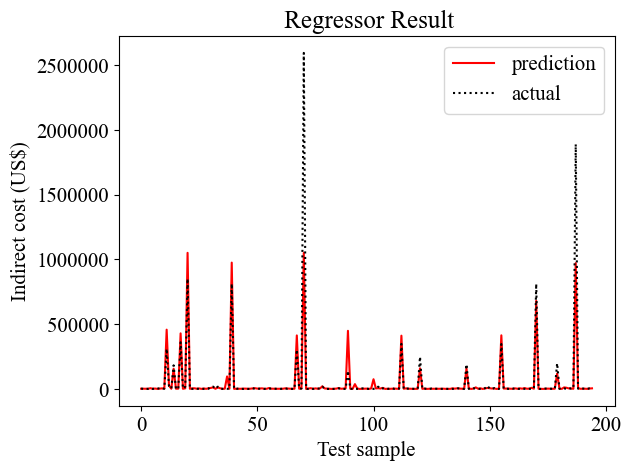

In [10]:

import numpy as np
import matplotlib.pyplot as plt

# Decalring numpy array variable

xAxis = np.arange(y_test.shape[0])

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 15})
plt.ticklabel_format(style='plain', axis='y')
plt.title(" Regressor Result")
plt.xlabel("Test sample")
plt.ylabel("Indirect cost (US$)")
plt.plot(xAxis, y_pred, color ="red")
plt.plot(xAxis, y_test, color ="black",linestyle='dotted')
plt.legend(['prediction', 'actual']);
plt.show()